In [4]:
from skimage import io
import matplotlib.pyplot as plt
import os

### Rename

In [ ]:
# rename dataset
map_dir = 'maps_custom'
# load image
map_list = os.listdir(map_dir)
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.jpg') or map_name.endswith('.png'):
        img = io.imread(os.path.join(map_dir, map_name))
        plt.imsave(os.path.join(map_dir, f'{i}.png'), img)
        print(f'Renamed {map_name} to {i}.png')
        # remove original png file
    # os.remove(os.path.join(map_dir, map_name))
# plt.imshow(img)
# plt.show()    


Renamed 1.png to 1.jpg
Renamed 10.png to 2.jpg
Renamed 100.png to 3.jpg
Renamed 11.png to 4.jpg
Renamed 12.png to 5.jpg
Renamed 13.png to 6.jpg
Renamed 14.png to 7.jpg
Renamed 15.png to 8.jpg
Renamed 16.png to 9.jpg
Renamed 17.png to 10.jpg
Renamed 18.png to 11.jpg
Renamed 19.png to 12.jpg
Renamed 2.png to 13.jpg
Renamed 20.png to 14.jpg
Renamed 21.png to 15.jpg
Renamed 22.png to 16.jpg
Renamed 23.png to 17.jpg
Renamed 24.png to 18.jpg
Renamed 25.png to 19.jpg
Renamed 26.png to 20.jpg
Renamed 27.png to 21.jpg
Renamed 28.png to 22.jpg
Renamed 29.png to 23.jpg
Renamed 3.png to 24.jpg
Renamed 30.png to 25.jpg
Renamed 31.png to 26.jpg
Renamed 32.png to 27.jpg
Renamed 33.png to 28.jpg
Renamed 34.png to 29.jpg
Renamed 35.png to 30.jpg
Renamed 36.png to 31.jpg
Renamed 37.png to 32.jpg
Renamed 38.png to 33.jpg
Renamed 39.png to 34.jpg
Renamed 4.png to 35.jpg
Renamed 40.png to 36.jpg
Renamed 41.png to 37.jpg
Renamed 42.png to 38.jpg
Renamed 43.png to 39.jpg
Renamed 44.png to 40.jpg
Renamed 45.p

(199, 199, 3)


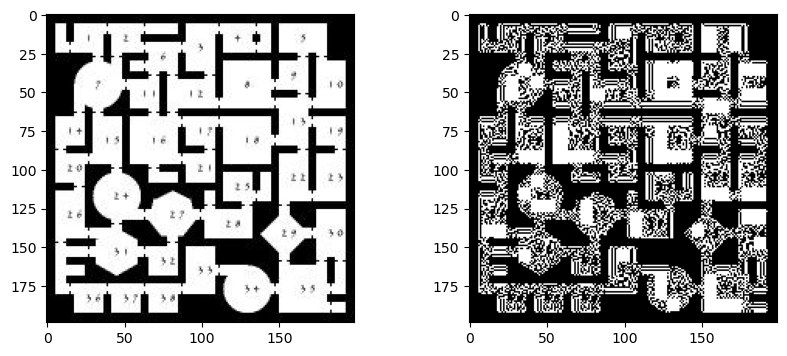

In [85]:
img1 = io.imread("maps_custom/1.jpg")
img2 = io.imread("maps_custom/1.jpg",1).astype('int')
print(img1.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')

Original shape: (199, 199, 3)


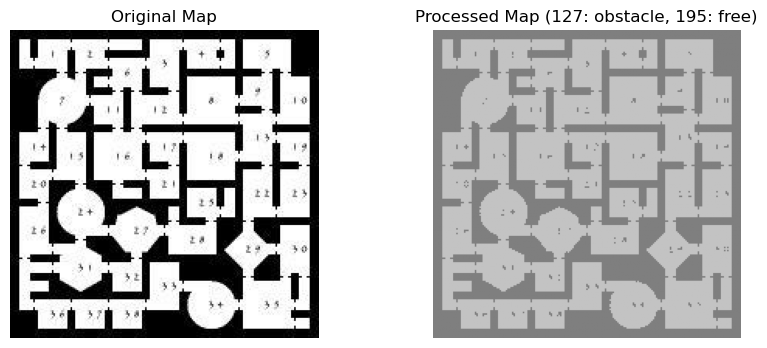

In [2]:
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- 1. Read the image ---
img = io.imread("maps_custom/1.jpg")
print("Original shape:", img.shape)

# --- 2. Convert to grayscale ---
# Converts RGB -> single-channel (0–255)
gray = color.rgb2gray(img)          # normalized float (0–1)
gray = (gray * 255).astype(np.uint8)

# --- 3. Threshold to binary map ---
# You may adjust 127 depending on your map brightness
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# --- 4. Map binary values to your custom values ---
# 255 → free, 0 → obstacle
# We map 0 → 127 (obstacle), 255 → 195 (free)
mapped = np.where(binary == 0, 127, 195).astype(np.uint8)

# --- 5. Visualize ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Map")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Processed Map (127: obstacle, 195: free)")
plt.imshow(mapped, cmap='gray', vmin=0, vmax=255)
plt.axis("off")

plt.show()


Found enclosed (inaccessible) free regions:
 - label 2, area 49 pixels
Resized shape: (200, 200)


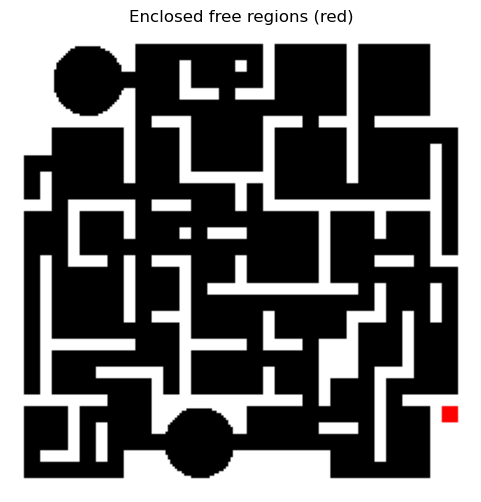

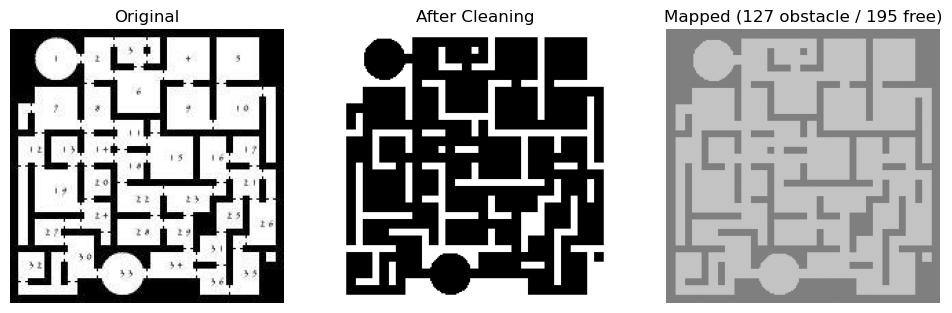

In [ ]:
from skimage import io, color, morphology
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- 1. Read and convert to grayscale ---
img = io.imread("maps_custom/2.jpg")

if img.shape[-1] == 4:
    img = img[:, :, :3]

gray = color.rgb2gray(img)
gray = (gray * 255).astype(np.uint8)

# --- 2. Threshold to binary (walls vs background) ---
# Invert threshold if needed (depending on map color)
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# --- 3. Remove small noise ---
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)
# cleaned = cv2.medianBlur(cleaned, 1)
# cleaned = morphology.opening(binary, morphology.disk(1))

# --- 4. Optionally, remove small blobs by area ---
# This filters out remaining small connected components
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
# min_area = 10   # adjust depending on how big your room numbers are
# filtered = np.zeros_like(cleaned)
# for i in range(1, num_labels):
#     if stats[i, cv2.CC_STAT_AREA] > min_area:
#         filtered[labels == i] = 255

# --- Check for inaccessible (enclosed) free areas ---
# In `cleaned`: 255 = obstacle, 0 = free
free_mask = (cleaned == 0).astype(np.uint8)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(free_mask, connectivity=8)

enclosed_labels = []
h, w = free_mask.shape
for lbl in range(1, num_labels):
    mask_lbl = (labels == lbl)
    touches_border = mask_lbl[0, :].any() or mask_lbl[h-1, :].any() or mask_lbl[:, 0].any() or mask_lbl[:, w-1].any()
    area_lbl = int(stats[lbl, cv2.CC_STAT_AREA])
    
    if touches_border:
        continue
    if area_lbl > 20000:
        continue
    enclosed_labels.append((lbl, area_lbl))

if enclosed_labels:
    print("Found enclosed (inaccessible) free regions:")
    for lbl, area in enclosed_labels:
        print(f" - label {lbl}, area {area} pixels")
    # Visualize enclosed regions (red) over the cleaned map
    overlay = np.stack([cleaned]*3, axis=-1).astype(np.uint8)  # RGB grayscale base
    for lbl, _ in enclosed_labels:
        overlay[labels == lbl] = [255, 0, 0]  # red
    plt.figure(figsize=(6,6))
    plt.title("Enclosed free regions (red)")
    plt.imshow(overlay)
    plt.axis("off")
else:
    print("No enclosed free regions detected (all free areas connect to border).")

target_shape = (200, 200)    # <-- desired size
resized = cv2.resize(cleaned, target_shape, interpolation=cv2.INTER_NEAREST)
print("Resized shape:", resized.shape)

resized_2d = np.ascontiguousarray(resized.astype(np.uint8))


# --- 5. Map pixel values to RL values ---
# 127 = obstacle, 195 = free
mapped = np.where(resized_2d == 255, 127, 195).astype(np.uint8)

# --- 6. Visualize ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("After Cleaning")
plt.imshow(cleaned, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Mapped (127 obstacle / 195 free)")
plt.imshow(mapped, cmap='gray', vmin=0, vmax=255)
plt.axis("off")

plt.show()


### Process & Save

In [ ]:
# process and save the processed map
map_dir = 'maps_custom'
# load image
map_list = os.listdir(map_dir)
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.jpg'):
        img = io.imread(os.path.join(map_dir, map_name))
        # if img.shape[-1] == 4:
        img = img[:, :, :3]
        gray = color.rgb2gray(img)
        gray = (gray * 255).astype(np.uint8)

        _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

        target_shape = (200, 200)
        resized = cv2.resize(cleaned, target_shape, interpolation=cv2.INTER_NEAREST)

        resized_2d = np.ascontiguousarray(resized.astype(np.uint8))

        mapped = np.where(resized_2d == 255, 127, 195).astype(np.uint8)

        os.makedirs(os.path.join(map_dir, 'clean'), exist_ok=True)
        save_path = os.path.join(map_dir, f'clean/{i}.png')
        cv2.imwrite(save_path, mapped)
        # plt.imsave(save_path, mapped, cmap='gray', vmin=0, vmax=255)
        print(f'Processed and saved {map_name} as {i}.png')

Processed and saved 1.jpg as 1.png
Processed and saved 10.jpg as 2.png
Processed and saved 100.jpg as 3.png
Processed and saved 11.jpg as 4.png
Processed and saved 12.jpg as 5.png
Processed and saved 13.jpg as 6.png
Processed and saved 14.jpg as 7.png
Processed and saved 15.jpg as 8.png
Processed and saved 16.jpg as 9.png
Processed and saved 17.jpg as 10.png
Processed and saved 18.jpg as 11.png
Processed and saved 19.jpg as 12.png
Processed and saved 2.jpg as 13.png
Processed and saved 20.jpg as 14.png
Processed and saved 21.jpg as 15.png
Processed and saved 22.jpg as 16.png
Processed and saved 23.jpg as 17.png
Processed and saved 24.jpg as 18.png
Processed and saved 25.jpg as 19.png
Processed and saved 26.jpg as 20.png
Processed and saved 27.jpg as 21.png
Processed and saved 28.jpg as 22.png
Processed and saved 29.jpg as 23.png
Processed and saved 3.jpg as 24.png
Processed and saved 30.jpg as 25.png
Processed and saved 31.jpg as 26.png
Processed and saved 32.jpg as 27.png
Processed an

### Check enclosed area

In [14]:
map_dir = 'maps_custom/clean'
# load image
map_list = os.listdir(map_dir)
c = 0
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.png'):
        img = io.imread(os.path.join(map_dir, map_name))
        free_mask = (img == 195).astype(np.uint8)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(free_mask, connectivity=8)

        enclosed_labels = []
        h, w = free_mask.shape
        for lbl in range(1, num_labels):
            mask_lbl = (labels == lbl)
            touches_border = mask_lbl[0, :].any() or mask_lbl[h-1, :].any() or mask_lbl[:, 0].any() or mask_lbl[:, w-1].any()
            area_lbl = int(stats[lbl, cv2.CC_STAT_AREA])
            # skip regions that touch the border or are too large (>20000)
            if touches_border:
                continue
            if area_lbl > 20000:
                continue
            enclosed_labels.append((lbl, area_lbl))

        if enclosed_labels:
            print(f"Processing map: {map_name}")
            print("Found enclosed free regions:")
            for lbl, area in enclosed_labels:
                print(f" - label {lbl}, area {area} pixels")
            c += 1
        
print("Total count:", c)

Total count: 0


### Remove enclosed area

In [13]:
map_dir = 'maps_custom/clean'
# load image
map_list = os.listdir(map_dir)
c = 0
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.png'):
        img = io.imread(os.path.join(map_dir, map_name))
        free_mask = (img == 195).astype(np.uint8)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(free_mask, connectivity=8)

        enclosed_labels = []
        h, w = free_mask.shape
        for lbl in range(1, num_labels):
            mask_lbl = (labels == lbl)
            touches_border = mask_lbl[0, :].any() or mask_lbl[h-1, :].any() or mask_lbl[:, 0].any() or mask_lbl[:, w-1].any()
            area_lbl = int(stats[lbl, cv2.CC_STAT_AREA])
            # skip regions that touch the border or are too large (>20000)
            if touches_border:
                continue
            if area_lbl > 20000:
                continue
            enclosed_labels.append((lbl, area_lbl))

        if enclosed_labels:
            print(f"Remove in map: {map_name}")
            for lbl, area in enclosed_labels:
                print(f" - label {lbl}, area {area} pixels")
                # remove enclosed regions by setting them to obstacle (127)
                img[labels == lbl] = 127
                save_path = os.path.join(map_dir, map_name)
                cv2.imwrite(save_path, img)


Remove in map: 11.png
 - label 2, area 529 pixels
Remove in map: 13.png
 - label 2, area 49 pixels
Remove in map: 26.png
 - label 2, area 529 pixels
Remove in map: 28.png
 - label 1, area 217 pixels
Remove in map: 30.png
 - label 2, area 133 pixels
Remove in map: 32.png
 - label 1, area 133 pixels
Remove in map: 33.png
 - label 2, area 133 pixels
Remove in map: 37.png
 - label 2, area 49 pixels
Remove in map: 39.png
 - label 2, area 49 pixels
Remove in map: 43.png
 - label 2, area 49 pixels
Remove in map: 50.png
 - label 2, area 133 pixels
Remove in map: 54.png
 - label 2, area 49 pixels
Remove in map: 62.png
 - label 1, area 49 pixels
 - label 3, area 49 pixels
Remove in map: 64.png
 - label 2, area 133 pixels
Remove in map: 66.png
 - label 2, area 49 pixels
Remove in map: 73.png
 - label 2, area 49 pixels
Remove in map: 8.png
 - label 1, area 133 pixels
Remove in map: 98.png
 - label 1, area 133 pixels


### Add Start (sample)

Placed start centered at (162, 170).
Process map: 99.png


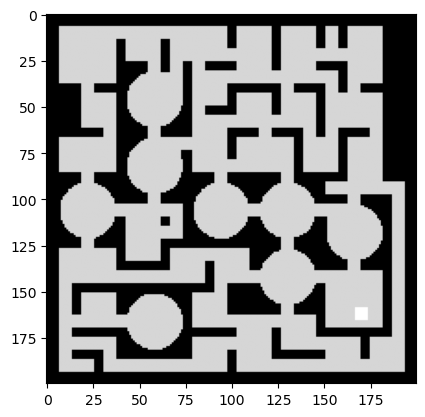

In [29]:
# remove old start region (set back to free value 195)
if (img == 208).any():
    img[img == 208] = 195
    print("removed old start region.")

# add a random 7x7 start region (value 208) inside a free area (value 195) in `img`
kernel7 = np.ones((7, 7), np.uint8)
free_mask = (img == 195).astype(np.uint8)

# erosion finds centers where a full 7x7 block is free
eroded = cv2.erode(free_mask, kernel7, iterations=1)
ys, xs = np.where(eroded == 1)

if len(ys) == 0:
    # fallback: pick any free pixel and clamp the 7x7 window to image bounds
    ys, xs = np.where(free_mask == 1)
    if len(ys) == 0:
        print("No free area (value 195) found to place start.")
    else:
        idx = np.random.choice(len(ys))
        cy, cx = int(ys[idx]), int(xs[idx])
        cy = np.clip(cy, 3, img.shape[0] - 4)
        cx = np.clip(cx, 3, img.shape[1] - 4)
        y0, y1 = cy - 3, cy + 4
        x0, x1 = cx - 3, cx + 4
        img[y0:y1, x0:x1] = 208
        print(f"Placed start (fallback) centered at ({cy}, {cx}).")
else:
    idx = np.random.choice(len(ys))
    cy, cx = int(ys[idx]), int(xs[idx])
    y0, y1 = cy - 3, cy + 4
    x0, x1 = cx - 3, cx + 4
    img[y0:y1, x0:x1] = 208
    print(f"Placed start centered at ({cy}, {cx}).")

# save and visualize
print("Process map:", map_name)
save_path = os.path.join(map_dir, map_name) 
cv2.imwrite(save_path, img.astype(np.uint8))
plt.imshow(img, cmap='gray')

Loop

Placed start centered at (140, 187).
Process map: 1.png
Placed start centered at (110, 185).
Process map: 10.png
Placed start centered at (114, 18).
Process map: 100.png
Placed start centered at (65, 154).
Process map: 11.png
Placed start centered at (51, 82).
Process map: 12.png
Placed start centered at (83, 43).
Process map: 13.png
Placed start centered at (131, 120).
Process map: 14.png
Placed start centered at (18, 70).
Process map: 15.png
Placed start centered at (71, 65).
Process map: 16.png
Placed start centered at (56, 62).
Process map: 17.png
Placed start centered at (81, 172).
Process map: 18.png
Placed start centered at (82, 23).
Process map: 19.png
Placed start centered at (55, 154).
Process map: 2.png
Placed start centered at (36, 132).
Process map: 20.png
Placed start centered at (46, 118).
Process map: 21.png
Placed start centered at (108, 36).
Process map: 22.png
Placed start centered at (176, 122).
Process map: 23.png
Placed start centered at (18, 87).
Process map: 24.

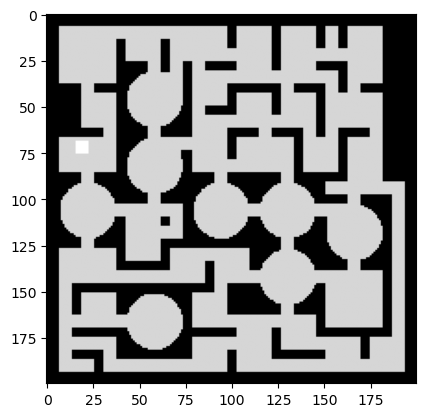

In [ ]:
map_dir = 'maps_custom/clean'
# load image
map_list = os.listdir(map_dir)
c = 0
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.png'):
        img = io.imread(os.path.join(map_dir, map_name))
        # remove old start region (set back to free value 195)
        if (img == 208).any():
            img[img == 208] = 195
            print("removed old start region.")

        # add a random 7x7 start region (value 208) inside a free area (value 195) in `img`
        kernel7 = np.ones((7, 7), np.uint8)
        free_mask = (img == 195).astype(np.uint8)

        # erosion finds centers where a full 7x7 block is free
        eroded = cv2.erode(free_mask, kernel7, iterations=1)
        ys, xs = np.where(eroded == 1)

        if len(ys) == 0:
            # fallback: pick any free pixel and clamp the 7x7 window to image bounds
            ys, xs = np.where(free_mask == 1)
            if len(ys) == 0:
                print("No free area (value 195) found to place start.")
            else:
                idx = np.random.choice(len(ys))
                cy, cx = int(ys[idx]), int(xs[idx])
                cy = np.clip(cy, 3, img.shape[0] - 4)
                cx = np.clip(cx, 3, img.shape[1] - 4)
                y0, y1 = cy - 3, cy + 4
                x0, x1 = cx - 3, cx + 4
                img[y0:y1, x0:x1] = 208
                print(f"Placed start (fallback) centered at ({cy}, {cx}).")
        else:
            idx = np.random.choice(len(ys))
            cy, cx = int(ys[idx]), int(xs[idx])
            y0, y1 = cy - 3, cy + 4
            x0, x1 = cx - 3, cx + 4
            img[y0:y1, x0:x1] = 208
            print(f"Placed start centered at ({cy}, {cx}).")

        print("Process map:", map_name)
        save_path = os.path.join(map_dir, map_name) 
        cv2.imwrite(save_path, img.astype(np.uint8))

check if all maps have start

In [32]:
map_dir = 'maps_custom/clean'
# load image
c = 0
map_list = os.listdir(map_dir)
for i, map_name in enumerate(map_list, start=1):
    if map_name.endswith('.png'):
        img = io.imread(os.path.join(map_dir, map_name))
        if (img == 208).any():
            c += 1
        else:
            print(f"Map {map_name} is missing start region (208).")
print("Total maps with start region:", c)

Total maps with start region: 100


[[127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 ...
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]]
(200, 200)


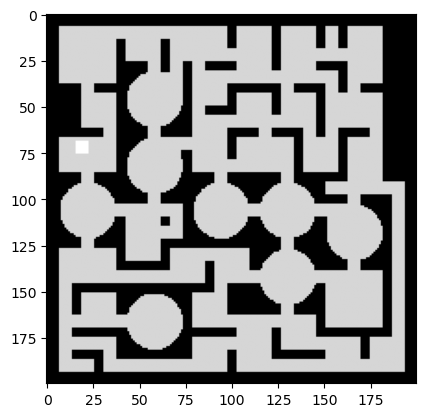

In [34]:
img = io.imread("maps_custom/clean/99.png").astype('int')
# img = io.imread("maps_test/1.png",1).astype('int')
print(img)
print(img.shape)
plt.imshow(img,cmap='gray')

(100, 100)


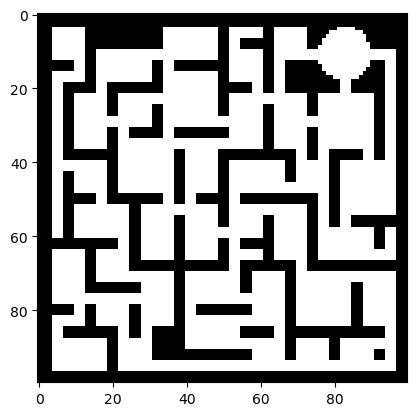

In [15]:
from skimage.measure import block_reduce
import numpy as np
reduced_img = block_reduce(img, 2, func=np.min)
print(reduced_img.shape)
plt.imshow(reduced_img,cmap='gray')

C:\Users\jingj\AppData\Local\Temp\ipykernel_11100\279764363.py:3: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(cropped_img,cmap='gray')
C:\Users\jingj\AppData\Local\Temp\ipykernel_11100\279764363.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(cropped_img,cmap='gray')


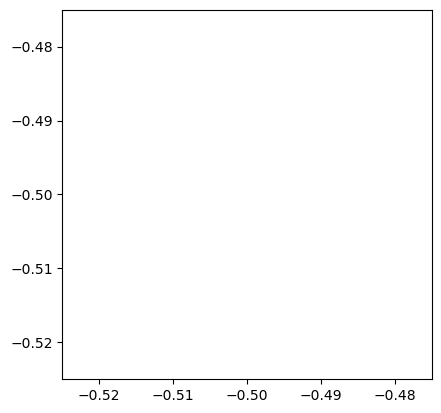

In [4]:
# crop img
cropped_img = reduced_img[150:170, 150:200]
plt.imshow(cropped_img,cmap='gray')

C:\Users\jingj\AppData\Local\Temp\ipykernel_11100\441325513.py:7: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(cropped_img,cmap='gray')
C:\Users\jingj\AppData\Local\Temp\ipykernel_11100\441325513.py:7: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(cropped_img,cmap='gray')


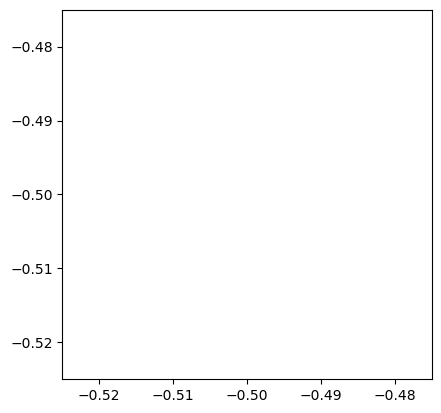

In [5]:
# annotate value of each different value
unique_values = np.unique(cropped_img)
for value in unique_values:
    y, x = np.where(cropped_img == value)
    plt.text(x[0], y[0], value, ha='center', va='center', color='red')

plt.imshow(cropped_img,cmap='gray')